# Read the data 

In [481]:
import pandas as pd
import numpy as np

data=pd.read_csv('Multi-Year Price Data (Aggregate).csv')
data.head()

,Date,Price
0,1/1/2012,99
1,1/2/2012,95
2,1/3/2012,96
3,1/4/2012,95
4,1/5/2012,93


#checking isnull value

In [482]:
#checking isnull value
data['Price'].isnull().sum()

0

In [483]:
#appending date-transformations
data['Year'] = pd.to_datetime(data['Date']).apply(lambda time: time.year)
data['Month'] = pd.to_datetime(data['Date']).apply(lambda time: time.month)
data['Day'] = pd.to_datetime(data['Date']).apply(lambda time: time.day)
data['Quarter'] = pd.to_datetime(data['Date']).apply(lambda time: time.quarter)
data.head()

,Date,Price,Year,Month,Day,Quarter
0,1/1/2012,99,2012,1,1,1
1,1/2/2012,95,2012,1,2,1
2,1/3/2012,96,2012,1,3,1
3,1/4/2012,95,2012,1,4,1
4,1/5/2012,93,2012,1,5,1


C:\Users\91951\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Price'>

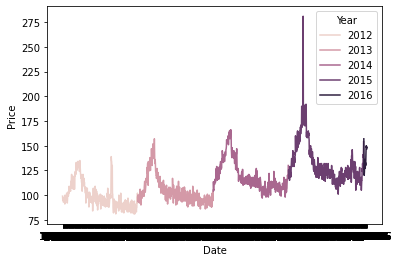

In [484]:
#Data visualisation
import seaborn as sns
sns.lineplot(data['Date'],data['Price'],hue=data['Year'])


#from first sight, it looks like there is trend in data 
#looking closely

<AxesSubplot:xlabel='Month', ylabel='Price'>

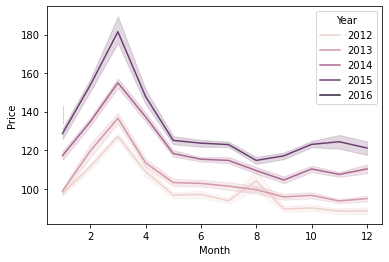

In [485]:
sns.lineplot(x=data['Month'],y=data['Price'],hue=data['Year'])

# Prices values behaving same across all years in different months.
# There is substantial YoY price growth

#Patterns in Days across months

<AxesSubplot:xlabel='Day', ylabel='Price'>

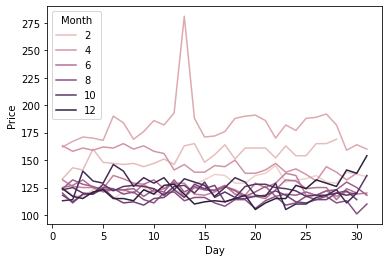

In [486]:

tmp=data[data['Year']==2015]
sns.lineplot(x=tmp['Day'],y=tmp['Price'],hue=tmp['Month'])

#Some months show larger range of hotel price values  aka March, April
#There is no visisble trend across days in one month

#Smoothing data for understand and model variability across days

In [487]:
#smooth prices using moving average of 5 prev points
data['price_smooth']=(data['Price'].shift(0)+data['Price'].shift(+1)+data['Price'].shift(+2)+data['Price'].shift(+4)+data['Price'].shift(+5))/5
ind=data.index[data['price_smooth'].isnull()==True]
tmp=data.loc[ind]['Price']
data.loc[ind,['price_smooth']]=tmp
data.head(10)

,Date,Price,Year,Month,Day,Quarter,price_smooth
0,1/1/2012,99,2012,1,1,1,99.0
1,1/2/2012,95,2012,1,2,1,95.0
2,1/3/2012,96,2012,1,3,1,96.0
3,1/4/2012,95,2012,1,4,1,95.0
4,1/5/2012,93,2012,1,5,1,93.0
5,1/6/2012,93,2012,1,6,1,95.0
6,1/7/2012,95,2012,1,7,1,94.4
7,1/8/2012,96,2012,1,8,1,95.0
8,1/9/2012,98,2012,1,9,1,95.4
9,1/10/2012,98,2012,1,10,1,95.6


<AxesSubplot:xlabel='Day', ylabel='price_smooth'>

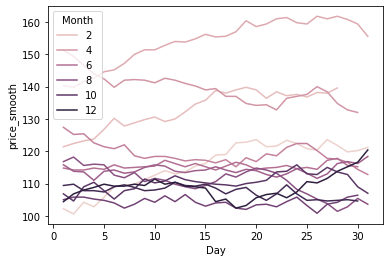

In [488]:
tmp=data[data['Year']==2014]
sns.lineplot(x=tmp['Day'],y=tmp['price_smooth'],hue=tmp['Month'])

2012 is a leap year. It has extra one day. Storing avg of 28/02/2014 and 29/02/2014 as 28/02/2014 price value.
removing 29/02/2014 from data for computation purposes
While prediction we will use same estimate for 28/02 and 29/02 

In [489]:
#2012 is a leap year. It has extra one day. Storing avg of 28/02/2014 and 29/02/2014 as 28/02/2014 price value.
#removing 29/02/2014 from data for computation purposes
#While prediction we will use same estimate for 28/02 and 29/02 

tmpval=(data.iloc[58]['price_smooth']+data.iloc[59]['price_smooth'])/2
data.loc[58, ['price_smooth']]=tmpval
data.drop([59],inplace=True)


 Analysing Year over Year growth

In [490]:
# Analysing Year over Year growth
def yoy(y1,y2):
    return 100.0*np.mean((y1-y2)/y1)



In [491]:
X=pd.DataFrame()
for i in [2012,2013,2014,2015,2016]:
    X[i]=pd.Series(data[data['Year']==i]['price_smooth']).reset_index()['price_smooth']
X.head()


,2012,2013,2014,2015,2016
0,99.0,96.8,102.2,122.2,140.8
1,95.0,96.2,100.6,122.0,143.2
2,96.0,96.4,104.2,119.0,138.8
3,95.0,96.8,102.8,121.0,134.8
4,93.0,97.4,105.8,124.2,138.2


In [492]:
YoY=[yoy(X[2013],X[2012]),yoy(X[2014],X[2013]),yoy(X[2015],X[2014]),yoy(X[2016],X[2015])]
YoY

[4.863786242297976, 12.163747166655416, 9.09107390457533, 10.75570569940625]

Experiment setup

In [493]:
#Goal: estimate hotel price for feb 2020 
#Evaluation metric: Root mean squared error
#Two validation set: 
#(A) Year = 2015 data 
#(B) Year = 2016 Jan Month data 

Val1=X[2015]
Val2=X[0:16][2016]

# Training data: 
# (A)using 2012 data 
# (B)using 2012-2015 data

X_train1=X[2012]
X_train2=X_train1.append(X[2013])
X_train2=X_train2.append(X[2014])
X_train2=X_train2.append(X[2015])

metrics_Train2012_Val2015=[]
metrics_Train2012_Val2016=[]
metrics_Train2012To2015_Val2016=[]
#'model-name','config',metric
#config(traindata-Valdata)= {A-A,A-B,B-A,B-B}


C:\Users\91951\AppData\Local\Temp\ipykernel_78520\1799290940.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train2=X_train1.append(X[2013])
C:\Users\91951\AppData\Local\Temp\ipykernel_78520\1799290940.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train2=X_train2.append(X[2014])
C:\Users\91951\AppData\Local\Temp\ipykernel_78520\1799290940.py:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train2=X_train2.append(X[2015])


#Model 1: estimate as prev-day's value
#Model 2 estimate as prev-year's value
#model 3 : mean of prev year's YoY growth and scaling prev-year's valus with constant growth value
#model 4: training Autoregressive model for YoY growth and scaling prev-year's valus with predicted growth

In [494]:
#Model 1: estimate as prev-day's value

#use last value of X_train1 as prediction for Val1

def Model1(X_train,Val,tag):
    ypred=X_train.iloc[len(X_train)-1]*np.ones([len(Val),1])
    y=Val
    return [tag,np.sqrt(mse(y,ypred))]

metrics_Train2012_Val2015.append(Model1(X_train1,Val1,'Prev-Day value'))
metrics_Train2012_Val2016.append(Model1(X_train1,Val2,'Prev-Day value'))
metrics_Train2012To2015_Val2016.append(Model1(X_train2,Val2,'Prev-Day value'))



#Using 2012 data for forecasting values of 2015 and 2016 gives larger error value
#using 2015 data for forecasting values of 2016 has 7.07

#Conclusion: Cannot be used to forecast next 4 yrs values

In [495]:
#Model 2 estimate as prev-year's value

def Model2(X_train,Val,tag):
    ypred=X_train.iloc[0:len(Val)]
    y=Val
    return [tag,np.sqrt(mse(y,ypred))]


metrics_Train2012_Val2015.append(Model2(X_train1,Val1,'Prev Years value'))
metrics_Train2012_Val2016.append(Model2(X_train1,Val2,'Prev Years value'))
metrics_Train2012To2015_Val2016.append(Model2(X[2015],Val2,'Prev Years value'))

print(metrics_Train2012_Val2015)
print(metrics_Train2012_Val2016)
print(metrics_Train2012To2015_Val2016)

#Conclusion: Prev-year value estimate farther values better 
#Can be used to forecast Feb 2020 values

[['Prev-Day value', 43.19452168153622], ['Prev Years value', 34.363719127994464]]
[['Prev-Day value', 44.21832199439503], ['Prev Years value', 41.77430430300426]]
[['Prev-Day value', 7.07884171316184], ['Prev Years value', 15.593989226621902]]


#Conclusion: Prev-year value estimate farther values better 
#Can be used to forecast Feb 2020 values

In [496]:
#model 3 : mean of prev year's YoY growth and scaling prev-year's valus with constant growth value
def Model3(X_train,Val,tag,sc):
    ypred=sc*X_train.iloc[0:len(Val)]
    y=Val
    return [tag,np.sqrt(mse(y,ypred))]

#using 2012-2013 growth to the power (year-diff)
factor=1+ (YoY[0]/100.0)
sc=pow(factor ,(2015-2012))
metrics_Train2012_Val2015.append(Model3(X_train1,Val1,'YoY constant growth factor',sc))

#using 2012-2013 growth to the power (year-diff)
factor=1+ (YoY[0]/100.0)
sc=pow(factor ,(2016-2012))

metrics_Train2012_Val2016.append(Model3(X_train1,Val2,'YoY constant growth factor',sc))


#using 2012-2016 growth to the power (year-diff)
factor=1+ (np.mean(YoY)/100.0)
sc=pow(factor ,(2016-2015))


metrics_Train2012To2015_Val2016.append(Model3(X[2015],Val2,'YoY constant growth factor',sc))

#Recency data and YoY growth gives lesser errors
#modeling YoY

#Recency data and YoY growth gives lesser errors
#modeling YoY

In [497]:
#model 4: training Autoregressive model for YoY growth and scaling prev-year's valus with predicted growth
from statsmodels.tsa.ar_model import AutoReg

#using 2012-2013 growth to the power (year-diff)
factor=1+ (YoY[0]/100.0)
sc=pow(factor ,(2015-2012))
metrics_Train2012_Val2015.append(Model3(X_train1,Val1,'YoY predicted growth factor',sc))

#using 2012-2013 growth to the power (year-diff)
factor=1+ (YoY[0]/100.0)
sc=pow(factor ,(2016-2012))

metrics_Train2012_Val2016.append(Model3(X_train1,Val2,'YoY predicted growth factor',sc))


#using 2012-2016 growth to the power (year-diff)
mod = AutoReg(yoytrend, 1)
yoy_predicted = res.predict(4, 10)

factor=1+ (yoy_predicted[4]/100.0)
sc=pow(factor ,(2016-2015))

metrics_Train2012To2015_Val2016.append(Model3(X[2015],Val2,'YoY predicted growth factor',sc))




In [498]:
import seaborn as sns
import matplotlib.pyplot as plt
data=[metrics_Train2012_Val2015,metrics_Train2012_Val2016,metrics_Train2012To2015_Val2016]
print('metrics_Train2012_Val2015')
print(metrics_Train2012_Val2015)
print('metrics_Train2012_Val2016')
print(metrics_Train2012_Val2016)
print('metrics_Train2012To2015_Val2016')
print(metrics_Train2012To2015_Val2016)

metrics_Train2012_Val2015
[['Prev-Day value', 43.19452168153622], ['Prev Years value', 34.363719127994464], ['YoY constant growth factor', 20.41686672733187], ['YoY predicted growth factor', 20.41686672733187]]
metrics_Train2012_Val2016
[['Prev-Day value', 44.21832199439503], ['Prev Years value', 41.77430430300426], ['YoY constant growth factor', 22.001560309693268], ['YoY predicted growth factor', 22.001560309693268]]
metrics_Train2012To2015_Val2016
[['Prev-Day value', 7.07884171316184], ['Prev Years value', 15.593989226621902], ['YoY constant growth factor', 5.888675044840529], ['YoY predicted growth factor', 129.96120790591962]]


#Using constant growth YoY Model to generate Feb 2020 values

In [499]:


factor=1+ (np.mean(YoY)/100.0)
sc=pow(factor ,5)

ypred=sc*X[2015].iloc[31:60]
len(ypred)

index_ = np.arange(0,29)

febdf = ypred.reset_index()[2015]
print(febdf)

0     206.386207
1     211.048546
2     215.400062
3     222.548982
4     222.859805
5     227.211321
6     225.346385
7     230.319547
8     231.562837
9     227.832966
10    228.454611
11    229.076257
12    233.427773
13    237.779289
14    240.576693
15    237.779289
16    241.198338
17    248.036435
18    245.239032
19    241.198338
20    249.279726
21    245.239032
22    244.928209
23    245.860677
24    246.482322
25    244.306564
26    248.347258
27    253.631242
28    249.901371
Name: 2015, dtype: float64


In [500]:
#FOR FUTURE works
#model 5 : Autoregressive model(15) on training data 

#Not enough data to train with only with 2012 data model. 
#Using All data and 2016-validation

mod = AutoReg(X_train2, 120)
res = mod.fit()
ypred = res.predict(len(X_train2),len(X_train2)+15)
np.sqrt(mse(Val2,ypred))



C:\Users\91951\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91951\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91951\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


6.71351134027351